# Data and Imports

In [1]:



import pandas as pd
import numpy as np
import jsonlines
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import torch.nn as nn
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch_optimizer as optim


from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from importlib import reload
pd.set_option('display.max_rows', 500)
pd.set_option('display.float_format', '{:0.3f}'.format)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.options.display.width = 0
import warnings
import torchvision
warnings.filterwarnings('ignore')

from facebook_hateful_memes_detector.utils.globals import set_global, get_global
set_global("cache_dir", "/home/ahemf/cache/cache")
set_global("dataloader_workers", 4)
set_global("use_autocast", True)
set_global("models_dir", "/home/ahemf/cache/")

from facebook_hateful_memes_detector.utils import read_json_lines_into_df, in_notebook, set_device
get_global("cache_dir")
from facebook_hateful_memes_detector.models import Fasttext1DCNNModel, MultiImageMultiTextAttentionEarlyFusionModel, LangFeaturesModel, AlbertClassifer
from facebook_hateful_memes_detector.preprocessing import TextImageDataset, my_collate, get_datasets, get_image2torchvision_transforms, TextAugment
from facebook_hateful_memes_detector.preprocessing import DefinedRotation, QuadrantCut, ImageAugment
from facebook_hateful_memes_detector.training import *
import facebook_hateful_memes_detector
reload(facebook_hateful_memes_detector)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
set_device(device)


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
set_device(device)
device


device(type='cuda')

In [3]:
aug_speeds = {"keyboard": 117, "char_substitute": 109, "char_insert": 109, "char_swap": 114,
              "ocr": 114, "char_delete": 108,
              "word_insert": 0.0, "word_substitute": 0.0, "text_rotate": 32,
              "stopword_insert": 34, "word_join": 32, "word_cutout": 36,
              "w2v_insert": 0.0, "w2v_substitute": 0.0, 
              "fasttext": 137, "glove_twitter": 88, "glove_wiki": 82, "word2vec": 137,
              "synonym": 522, "split": 110, "sentence_shuffle": 67, "one_third_cut": 0.0, "half_cut":0.0}


- What Augs are useful
- What Text models perform best

In [4]:


choice_probas = {"keyboard": 0.1, "char_substitute": 0.0, "char_insert": 0.1, "char_swap": 0.1, "ocr": 0.0, "char_delete": 0.1,
                 "fasttext": 0.0, "glove_twitter": 0.0, "glove_wiki": 0.0, "word2vec": 0.0, "split": 0.1,
                 "stopword_insert": 0.3, "word_join": 0.1, "word_cutout": 0.8,
                 "text_rotate": 0.5, "sentence_shuffle": 0.5, "one_third_cut": 0.3, "half_cut":0.1}
preprocess_text = TextAugment([0.05, 0.05, 0.05, 0.35, 0.3, 0.2], choice_probas, fasttext_file="wiki-news-300d-1M-subword.bin")


data = get_datasets(data_dir="../data/", train_text_transform=preprocess_text, train_image_transform=None, 
                    test_text_transform=None, test_image_transform=None, 
                    cache_images = True, use_images = False, dev=False, test_dev=True,
                    keep_original_text=False, keep_original_image=False, 
                    keep_processed_image=True, keep_torchvision_image=False,)

# images = list(data["train"].img) + list(data["test"].img)
# pd.DataFrame({"img":images}).to_csv("image.csv", header=None, index=None)

# ImageAugment([0.2, 0.5, 0.3])


In [5]:
# data["train"].label.value_counts()
# train = data["train"]

# ones = train[train["label"] == 1]
# zeros = train[train["label"] == 0].sample(n=len(ones), replace=False)
# data["train"] = pd.concat((ones, zeros)).sample(frac=1.0)
# data["train"].label.value_counts()

# len(set(data["train"]["id"])) == data["train"].shape[0]


https://discuss.pytorch.org/t/how-to-implement-torch-optim-lr-scheduler-cosineannealinglr/28797/11

# Params

In [6]:
sgd = torch.optim.SGD
sgd_params = dict(lr=2e-2, momentum=0.9, dampening=0, weight_decay=0, nesterov=False)

rangerQH = optim.RangerQH
rangerQHparams = dict(lr=1e-3, betas=(0.9, 0.999), nus=(.7, 1.0),
    weight_decay=0.0,
    k=6,
    alpha=.5,
    decouple_weight_decay=True,
    eps=1e-8,)

adam = torch.optim.Adam
adam_params = params=dict(lr=1e-3, weight_decay=1e-7)

adamw = torch.optim.AdamW
adamw_params = dict(lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-2)

novograd = optim.NovoGrad
novograd_params = dict(lr= 1e-3,
    betas=(0.9, 0.999),
    eps=1e-8,
    weight_decay=0,
    grad_averaging=False,
    amsgrad=False,)

qhadam = optim.QHAdam
qhadam_params = dict(lr= 1e-3,
    betas=(0.9, 0.999),
    nus=(1.0, 1.0),
    weight_decay=0,
    decouple_weight_decay=False,
    eps=1e-8,)

radam = optim.RAdam
radam_params = dict(lr= 1e-3,
    betas=(0.9, 0.999),
    eps=1e-8,
    weight_decay=0,)

yogi = optim.Yogi
yogi_params = dict(lr= 1e-2,
    betas=(0.9, 0.999),
    eps=1e-3,
    initial_accumulator=1e-6,
    weight_decay=0)




In [7]:
batch_size=256
epochs = 10
optimizer = adam
optimizer_params = adam_params

scheduler_init_fn = get_multistep_lr([11, 13], gamma=0.25) # get_cosine_schedule_with_warmup # get_cosine_with_hard_restarts_schedule_with_warmup
scheduler_init_fn = get_cosine_schedule_with_warmup()
reg_sched = get_regularizer_scheduler()



# BERT Models

## Non Ensemble

## Head Ensemble

In [ ]:
adamw = torch.optim.AdamW
adamw_params = dict(lr=2e-4, betas=(0.9, 0.98), eps=1e-08, weight_decay=1e-2)
optimizer = adamw
optimizer_params = adamw_params

lr_strategy = {
    "model": {
        "lr": optimizer_params["lr"] / 1000,
        "finetune": False,
        "encoder": {
            "layer": {
                "2": {
                    "lr": optimizer_params["lr"] / 1e3,
                    "finetune": False
                },
                "3": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                },
                "4": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                },
                "5": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                }
            }
        },
    }
}

epochs = 24
batch_size = 256
model_fn = model_builder(AlbertClassifer,
                         dict(classifier_dims=256,
                              num_classes=2,
                              gaussian_noise=0.025,
                              dropout=0.05, # 0.15
                              word_masking_proba=0.1,
                              internal_dims=512,
                              final_layer_builder=fb_1d_loss_builder,
                              n_layers=2,
                              n_encoders=2,
                              n_decoders=2,
                              n_tokens_in=96,
                              n_tokens_out=16,
                              featurizer="transformer",
                              model='distilbert-nsp',
                              loss="focal",
                              classification_head="head_ensemble", # head_ensemble
                              dice_loss_coef=0.0,
                              auc_loss_coef=1.0,
                              attention_drop_proba=0.1,
                              finetune=False),
                         per_param_opts_fn=lr_strategy,
                         optimiser_class=optimizer,
                         optimiser_params=optimizer_params)

kfold = False
results, prfs = train_validate_ntimes(
    model_fn,
    data,
    batch_size,
    epochs,
    kfold=kfold,
    scheduler_init_fn=scheduler_init_fn,
    model_call_back=reg_sched, # reg_sched
    validation_epochs=[4, 7, 9, 11, 14, 17, 19, 23, 27, 31, 34, 37, 41, 44, 47, 51, 54],
    show_model_stats=False,
    sampling_policy="without_replacement")
r2, p2 = results, prfs
results
prfs


## Decoder Ensemble

Pick stored Model ./distilbert-nsp Model Class =  <class 'transformers.modeling_roberta.RobertaModel'> Tokenizer Class =  <class 'transformers.tokenization_roberta.RobertaTokenizer'>
Autocast =  True Epochs =  48 Divisor = 2 Examples = 4250 Batch Size =  256
Training Samples =  8500 Weighted Sampling =  True Num Batches =  17 Accumulation steps =  1



Epoch =  1 Loss = 0.825098 LR = 0.00000697



Epoch =  2 Loss = 0.645896 LR = 0.00001393



Epoch =  3 Loss = 0.574671 LR = 0.00002090



Epoch =  4 Loss = 0.543297 LR = 0.00002787


Proba       Preds    
         min   max   min max
Labels                      
0      0.367 0.473     0   0
1      0.368 0.473     0   0

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.400,"[0.6000945568084717, 0.39990541338920593]",0,0,0.385,"[0.6153837442398071, 0.38461625576019287]",0,0,0.417,"[0.5828951597213745, 0.4171048700809479]",0,1
1,0.402,"[0.5981106758117676, 0.4018893241882324]",0,1,0.402,"[0.5980411767959595, 0.40195876359939575]",0,1,0.441,"[0.5585863590240479, 0.44141364097595215]",0,1
2,0.406,"[0.5943883657455444, 0.40561163425445557]",0,0,0.381,"[0.6185457706451416, 0.381454199552536]",0,0,0.426,"[0.5735257863998413, 0.4264742136001587]",0,1
3,0.405,"[0.5945001244544983, 0.4054998457431793]",0,1,0.418,"[0.5816152691841125, 0.41838473081588745]",0,1,0.407,"[0.5931220650672913, 0.40687787532806396]",0,0
4,0.426,"[0.5740940570831299, 0.4259059727191925]",0,0,0.420,"[0.5800891518592834, 0.41991090774536133]",0,1,0.406,"[0.5943644046783447, 0.4056355953216553]",0,1


scores =  {'map': '0.5457', 'acc': '0.5000', 'auc': '0.5529'}
Epoch =  4 Train = 0.642595 Val = 0.552904



Epoch =  5 Loss = 0.528677 LR = 0.00003484



Epoch =  6 Loss = 0.518939 LR = 0.00004180



Epoch =  7 Loss = 0.514026 LR = 0.00004877


Proba       Preds    
         min   max   min max
Labels                      
0      0.298 0.526     0   1
1      0.342 0.532     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.420,"[0.5802394151687622, 0.4197605550289154]",0,1,0.496,"[0.5043643712997437, 0.49563562870025635]",0,1,0.485,"[0.5147221088409424, 0.4852779507637024]",0,0
1,0.375,"[0.6249499320983887, 0.37505006790161133]",0,0,0.420,"[0.5800890326499939, 0.4199109375476837]",0,0,0.427,"[0.5728524327278137, 0.4271475672721863]",0,1
2,0.412,"[0.5878139734268188, 0.41218602657318115]",0,0,0.414,"[0.5859416723251343, 0.4140583276748657]",0,0,0.429,"[0.5714441537857056, 0.4285558760166168]",0,1
3,0.421,"[0.5787840485572815, 0.4212159514427185]",0,0,0.478,"[0.5221962332725525, 0.4778037667274475]",0,1,0.400,"[0.6000701189041138, 0.39992988109588623]",0,1
4,0.442,"[0.5578620433807373, 0.4421379566192627]",0,0,0.476,"[0.5237613916397095, 0.47623854875564575]",0,0,0.435,"[0.564543604850769, 0.43545636534690857]",0,1


scores =  {'map': '0.5839', 'acc': '0.5100', 'auc': '0.6045'}
Epoch =  7 Train = 0.713388 Val = 0.604456



Epoch =  8 Loss = 0.502605 LR = 0.00005574



Epoch =  9 Loss = 0.495395 LR = 0.00006270


Proba       Preds    
         min   max   min max
Labels                      
0      0.299 0.536     0   1
1      0.365 0.536     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.407,"[0.592573881149292, 0.407426118850708]",0,0,0.429,"[0.5705748796463013, 0.42942512035369873]",0,1,0.513,"[0.48718690872192383, 0.5128130912780762]",1,0
1,0.412,"[0.5884096026420593, 0.4115903973579407]",0,0,0.450,"[0.549726665019989, 0.450273334980011]",0,0,0.368,"[0.6315464973449707, 0.3684535622596741]",0,0
2,0.452,"[0.5483077764511108, 0.45169225335121155]",0,1,0.463,"[0.5365434885025024, 0.46345657110214233]",0,1,0.461,"[0.5393917560577393, 0.46060821413993835]",0,0
3,0.442,"[0.557719886302948, 0.442280113697052]",0,1,0.422,"[0.5783543586730957, 0.4216456413269043]",0,0,0.423,"[0.5769619941711426, 0.4230380058288574]",0,0
4,0.501,"[0.4986051917076111, 0.5013948082923889]",1,0,0.408,"[0.591607391834259, 0.40839260816574097]",0,1,0.432,"[0.5678102374076843, 0.4321897625923157]",0,0


scores =  {'map': '0.5948', 'acc': '0.5080', 'auc': '0.6160'}
Epoch =  9 Train = 0.739943 Val = 0.615976



Epoch =  10 Loss = 0.496655 LR = 0.00006967



Epoch =  11 Loss = 0.487136 LR = 0.00007664


Proba       Preds    
         min   max   min max
Labels                      
0      0.280 0.470     0   0
1      0.330 0.476     0   0

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.390,"[0.6095772981643677, 0.3904227018356323]",0,1,0.416,"[0.5835922360420227, 0.4164077341556549]",0,0,0.369,"[0.6305584907531738, 0.36944150924682617]",0,0
1,0.395,"[0.6054102182388306, 0.39458978176116943]",0,0,0.410,"[0.5897958874702454, 0.41020408272743225]",0,1,0.454,"[0.545806348323822, 0.454193651676178]",0,0
2,0.430,"[0.5702168941497803, 0.4297831058502197]",0,1,0.404,"[0.5958451628684998, 0.40415483713150024]",0,0,0.372,"[0.6282511353492737, 0.3717488944530487]",0,0
3,0.373,"[0.6265984773635864, 0.3734014630317688]",0,0,0.390,"[0.6101253032684326, 0.3898746967315674]",0,1,0.357,"[0.6430834531784058, 0.35691654682159424]",0,0
4,0.435,"[0.564774751663208, 0.4352252185344696]",0,0,0.439,"[0.5608832836151123, 0.4391167163848877]",0,1,0.351,"[0.6488631963729858, 0.35113683342933655]",0,0


scores =  {'map': '0.5973', 'acc': '0.5000', 'auc': '0.6106'}
Epoch =  11 Train = 0.752349 Val = 0.610568



Epoch =  12 Loss = 0.483497 LR = 0.00008361



Epoch =  13 Loss = 0.486319 LR = 0.00009057



Epoch =  14 Loss = 0.492862 LR = 0.00009754


Proba       Preds    
         min   max   min max
Labels                      
0      0.254 0.474     0   0
1      0.321 0.496     0   0

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.421,"[0.5793059468269348, 0.4206939935684204]",0,1,0.439,"[0.5614545345306396, 0.4385455250740051]",0,1,0.345,"[0.6551902294158936, 0.34480977058410645]",0,0
1,0.403,"[0.5974583625793457, 0.4025416374206543]",0,1,0.410,"[0.5900934934616089, 0.4099065065383911]",0,0,0.385,"[0.6152442693710327, 0.3847557008266449]",0,1
2,0.408,"[0.5921034812927246, 0.407896488904953]",0,0,0.379,"[0.6210393905639648, 0.37896063923835754]",0,1,0.448,"[0.5520352125167847, 0.44796478748321533]",0,1
3,0.391,"[0.6093196868896484, 0.39068037271499634]",0,0,0.391,"[0.608833909034729, 0.3911661207675934]",0,1,0.369,"[0.6308984756469727, 0.36910155415534973]",0,1
4,0.400,"[0.6000285148620605, 0.39997148513793945]",0,1,0.402,"[0.5980679988861084, 0.401932030916214]",0,0,0.423,"[0.5772815942764282, 0.4227184057235718]",0,1


scores =  {'map': '0.5819', 'acc': '0.5000', 'auc': '0.6109'}
Epoch =  14 Train = 0.752583 Val = 0.610904



Epoch =  15 Loss = 0.478658 LR = 0.00009991



Epoch =  16 Loss = 0.483169 LR = 0.00009941



Epoch =  17 Loss = 0.481298 LR = 0.00009848


Proba       Preds    
         min   max   min max
Labels                      
0      0.242 0.534     0   1
1      0.310 0.534     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.426,"[0.5744381546974182, 0.4255618453025818]",0,1,0.470,"[0.5300424098968506, 0.4699576199054718]",0,1,0.511,"[0.4886360168457031, 0.5113639831542969]",1,1
1,0.438,"[0.5620801448822021, 0.43791982531547546]",0,0,0.468,"[0.5324897170066833, 0.4675102233886719]",0,1,0.436,"[0.5637885928153992, 0.43621140718460083]",0,0
2,0.426,"[0.5736509561538696, 0.42634907364845276]",0,1,0.409,"[0.5909866690635681, 0.4090133309364319]",0,0,0.529,"[0.47058194875717163, 0.5294180512428284]",1,0
3,0.416,"[0.5841505527496338, 0.415849506855011]",0,1,0.440,"[0.5595637559890747, 0.4404362440109253]",0,0,0.528,"[0.47241348028182983, 0.5275865197181702]",1,0
4,0.469,"[0.5309200882911682, 0.4690799117088318]",0,1,0.418,"[0.5821515321731567, 0.41784852743148804]",0,0,0.452,"[0.5479861497879028, 0.4520138204097748]",0,1


scores =  {'map': '0.5987', 'acc': '0.5320', 'auc': '0.6340'}
Epoch =  17 Train = 0.782744 Val = 0.633992



Epoch =  18 Loss = 0.472745 LR = 0.00009713



Epoch =  19 Loss = 0.467528 LR = 0.00009537


Proba       Preds    
         min   max   min max
Labels                      
0      0.112 0.552     0   1
1      0.205 0.552     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.386,"[0.6144185066223145, 0.38558149337768555]",0,0,0.444,"[0.5562803149223328, 0.44371968507766724]",0,0,0.390,"[0.610306441783905, 0.3896934986114502]",0,0
1,0.422,"[0.57750403881073, 0.42249593138694763]",0,1,0.371,"[0.6285915374755859, 0.37140846252441406]",0,1,0.374,"[0.6262048482894897, 0.37379521131515503]",0,0
2,0.479,"[0.5207474231719971, 0.47925254702568054]",0,1,0.479,"[0.5206669569015503, 0.4793330430984497]",0,1,0.445,"[0.5545477867126465, 0.4454522132873535]",0,1
3,0.444,"[0.5564906001091003, 0.44350939989089966]",0,0,0.505,"[0.49465054273605347, 0.5053494572639465]",1,0,0.443,"[0.5571738481521606, 0.44282615184783936]",0,1
4,0.453,"[0.5473753213882446, 0.45262467861175537]",0,1,0.368,"[0.6317079663276672, 0.36829203367233276]",0,1,0.474,"[0.5263757705688477, 0.47362422943115234]",0,1


scores =  {'map': '0.5810', 'acc': '0.5100', 'auc': '0.6228'}
Epoch =  19 Train = 0.793977 Val = 0.622792



Epoch =  20 Loss = 0.469692 LR = 0.00009321



Epoch =  21 Loss = 0.470404 LR = 0.00009068



Epoch =  22 Loss = 0.467867 LR = 0.00008779



Epoch =  23 Loss = 0.470881 LR = 0.00008457


Proba       Preds    
         min   max   min max
Labels                      
0      0.190 0.456     0   0
1      0.239 0.457     0   0

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.379,"[0.6212131977081299, 0.3787868022918701]",0,0,0.415,"[0.5851757526397705, 0.4148242473602295]",0,1,0.409,"[0.5910695195198059, 0.4089304506778717]",0,1
1,0.401,"[0.5989573001861572, 0.4010426998138428]",0,1,0.390,"[0.6100329160690308, 0.3899671137332916]",0,0,0.391,"[0.6089495420455933, 0.39105042815208435]",0,0
2,0.407,"[0.592668890953064, 0.40733104944229126]",0,0,0.411,"[0.5889946222305298, 0.4110053479671478]",0,1,0.403,"[0.5965722799301147, 0.40342772006988525]",0,0
3,0.420,"[0.5795732140541077, 0.42042678594589233]",0,1,0.435,"[0.5651326179504395, 0.43486741185188293]",0,0,0.415,"[0.5851686000823975, 0.41483134031295776]",0,1
4,0.334,"[0.6659610867500305, 0.3340389132499695]",0,0,0.444,"[0.5562049746513367, 0.4437950551509857]",0,0,0.396,"[0.6043424606323242, 0.3956575095653534]",0,1


scores =  {'map': '0.6066', 'acc': '0.5000', 'auc': '0.6370'}
Epoch =  23 Train = 0.807510 Val = 0.637048



Epoch =  24 Loss = 0.462486 LR = 0.00008105



Epoch =  25 Loss = 0.463121 LR = 0.00007726



Epoch =  26 Loss = 0.463304 LR = 0.00007324



Epoch =  27 Loss = 0.461171 LR = 0.00006901


Proba       Preds    
         min   max   min max
Labels                      
0      0.090 0.448     0   0
1      0.129 0.449     0   0

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.394,"[0.6063394546508789, 0.3936605453491211]",0,1,0.415,"[0.5848050713539124, 0.41519492864608765]",0,1,0.174,"[0.8259727954864502, 0.1740272045135498]",0,0
1,0.355,"[0.6451596021652222, 0.35484039783477783]",0,0,0.407,"[0.5927472710609436, 0.4072527587413788]",0,0,0.237,"[0.7629009485244751, 0.2370990663766861]",0,0
2,0.328,"[0.672205924987793, 0.32779404520988464]",0,0,0.285,"[0.7150153517723083, 0.28498464822769165]",0,1,0.397,"[0.6028529405593872, 0.3971470296382904]",0,1
3,0.390,"[0.6099593043327332, 0.39004066586494446]",0,0,0.363,"[0.6372870206832886, 0.3627130091190338]",0,1,0.327,"[0.6728334426879883, 0.32716652750968933]",0,0
4,0.332,"[0.6680387854576111, 0.3319612145423889]",0,0,0.425,"[0.5745916366577148, 0.42540833353996277]",0,1,0.408,"[0.5922638773918152, 0.4077360928058624]",0,1


scores =  {'map': '0.6037', 'acc': '0.5000', 'auc': '0.6393'}
Epoch =  27 Train = 0.824353 Val = 0.639304



Epoch =  28 Loss = 0.467099 LR = 0.00006461



Epoch =  29 Loss = 0.459498 LR = 0.00006009



Epoch =  30 Loss = 0.458401 LR = 0.00005548



Epoch =  31 Loss = 0.458091 LR = 0.00005082


Proba       Preds    
         min   max   min max
Labels                      
0      0.037 0.509     0   1
1      0.062 0.500     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.168,"[0.8319038152694702, 0.16809618473052979]",0,0,0.225,"[0.7746517658233643, 0.22534820437431335]",0,1,0.455,"[0.5448140501976013, 0.45518597960472107]",0,1
1,0.457,"[0.5434167385101318, 0.4565832316875458]",0,1,0.466,"[0.5336859822273254, 0.46631401777267456]",0,0,0.398,"[0.6023819446563721, 0.3976180851459503]",0,0
2,0.449,"[0.5509703159332275, 0.44902971386909485]",0,0,0.439,"[0.5614856481552124, 0.4385143518447876]",0,1,0.352,"[0.6478704810142517, 0.3521295189857483]",0,0
3,0.461,"[0.538793683052063, 0.46120622754096985]",0,0,0.251,"[0.7494940757751465, 0.2505059242248535]",0,0,0.451,"[0.5492171049118042, 0.4507828652858734]",0,0
4,0.453,"[0.5470227003097534, 0.4529772996902466]",0,1,0.432,"[0.5678631067276001, 0.4321368932723999]",0,1,0.433,"[0.567065954208374, 0.432934045791626]",0,0


scores =  {'map': '0.5878', 'acc': '0.5000', 'auc': '0.6369'}
Epoch =  31 Train = 0.834604 Val = 0.636936



Epoch =  32 Loss = 0.454717 LR = 0.00004616



Epoch =  33 Loss = 0.457907 LR = 0.00004153



Epoch =  34 Loss = 0.455820 LR = 0.00003697


Proba       Preds    
         min   max   min max
Labels                      
0      0.149 0.531     0   1
1      0.181 0.552     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.466,"[0.5344077348709106, 0.46559229493141174]",0,0,0.446,"[0.553673267364502, 0.44632673263549805]",0,1,0.449,"[0.5513861179351807, 0.44861382246017456]",0,0
1,0.267,"[0.7327166199684143, 0.2672833800315857]",0,0,0.396,"[0.6042191982269287, 0.3957808315753937]",0,1,0.503,"[0.49652907252311707, 0.5034708976745605]",1,0
2,0.433,"[0.567278265953064, 0.4327217936515808]",0,0,0.334,"[0.6660118103027344, 0.3339881896972656]",0,1,0.295,"[0.7045407891273499, 0.29545921087265015]",0,0
3,0.460,"[0.540385365486145, 0.45961466431617737]",0,1,0.488,"[0.512367308139801, 0.487632691860199]",0,0,0.315,"[0.6845744848251343, 0.3154255151748657]",0,1
4,0.473,"[0.5272260904312134, 0.47277384996414185]",0,1,0.516,"[0.4836903512477875, 0.5163096785545349]",1,0,0.311,"[0.6891961097717285, 0.31080394983291626]",0,1


scores =  {'map': '0.6021', 'acc': '0.5320', 'auc': '0.6435'}
Epoch =  34 Train = 0.840172 Val = 0.643544



Epoch =  35 Loss = 0.448771 LR = 0.00003253



Epoch =  36 Loss = 0.451330 LR = 0.00002824



Epoch =  37 Loss = 0.448327 LR = 0.00002413


Proba       Preds    
         min   max   min max
Labels                      
0      0.033 0.492     0   0
1      0.042 0.494     0   0

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.141,"[0.8594110012054443, 0.1405889391899109]",0,0,0.369,"[0.6314874887466431, 0.3685125410556793]",0,0,0.248,"[0.751669704914093, 0.24833029508590698]",0,0
1,0.414,"[0.5857557654380798, 0.41424426436424255]",0,1,0.471,"[0.5292710065841675, 0.4707289934158325]",0,1,0.448,"[0.5518244504928589, 0.44817548990249634]",0,1
2,0.424,"[0.5755685567855835, 0.4244315028190613]",0,0,0.458,"[0.5415646433830261, 0.4584353566169739]",0,1,0.390,"[0.609891414642334, 0.390108585357666]",0,1
3,0.413,"[0.5866910219192505, 0.4133089482784271]",0,1,0.330,"[0.6695516109466553, 0.3304484188556671]",0,0,0.428,"[0.5723395347595215, 0.4276605248451233]",0,1
4,0.269,"[0.7305426597595215, 0.2694573700428009]",0,0,0.351,"[0.6490057706832886, 0.3509942293167114]",0,1,0.471,"[0.5292710065841675, 0.4707289934158325]",0,1


scores =  {'map': '0.6072', 'acc': '0.5000', 'auc': '0.6489'}
Epoch =  37 Train = 0.846040 Val = 0.648888



Epoch =  38 Loss = 0.452470 LR = 0.00002026



Epoch =  39 Loss = 0.450696 LR = 0.00001664



Epoch =  40 Loss = 0.450273 LR = 0.00001331



Epoch =  41 Loss = 0.449442 LR = 0.00001030


Proba       Preds    
         min   max   min max
Labels                      
0      0.007 0.536     0   1
1      0.008 0.538     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.516,"[0.48431938886642456, 0.5156805515289307]",1,0,0.447,"[0.5534967184066772, 0.44650328159332275]",0,1,0.476,"[0.5240148901939392, 0.4759851098060608]",0,1
1,0.473,"[0.5267197489738464, 0.4732802212238312]",0,1,0.421,"[0.5787713527679443, 0.42122864723205566]",0,1,0.220,"[0.7799796462059021, 0.2200203686952591]",0,0
2,0.351,"[0.6487204432487488, 0.3512795865535736]",0,0,0.039,"[0.961204469203949, 0.03879553824663162]",0,0,0.507,"[0.49277347326278687, 0.5072265267372131]",1,1
3,0.215,"[0.7851301431655884, 0.21486985683441162]",0,0,0.352,"[0.6479186415672302, 0.3520813584327698]",0,1,0.261,"[0.7386264801025391, 0.2613735795021057]",0,0
4,0.305,"[0.6951888799667358, 0.30481114983558655]",0,0,0.493,"[0.5070685148239136, 0.4929314851760864]",0,0,0.508,"[0.49165356159210205, 0.508346438407898]",1,0


scores =  {'map': '0.6055', 'acc': '0.5220', 'auc': '0.6468'}
Epoch =  41 Train = 0.852030 Val = 0.646776



Epoch =  42 Loss = 0.442624 LR = 0.00000764



Epoch =  43 Loss = 0.449945 LR = 0.00000535



Epoch =  44 Loss = 0.444062 LR = 0.00000345


Proba       Preds    
         min   max   min max
Labels                      
0      0.005 0.544     0   1
1      0.005 0.546     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.467,"[0.5332367420196533, 0.4667632579803467]",0,0,0.473,"[0.527170717716217, 0.47282928228378296]",0,0,0.499,"[0.5009151697158813, 0.49908480048179626]",0,0
1,0.488,"[0.5117480158805847, 0.4882519543170929]",0,1,0.498,"[0.5023871660232544, 0.4976128339767456]",0,1,0.507,"[0.49266737699508667, 0.5073326230049133]",1,0
2,0.458,"[0.5424860715866089, 0.4575139582157135]",0,0,0.494,"[0.5059670209884644, 0.49403297901153564]",0,1,0.525,"[0.4754680097103119, 0.5245320200920105]",1,0
3,0.475,"[0.5253366231918335, 0.4746634364128113]",0,1,0.529,"[0.4709714651107788, 0.5290285348892212]",1,1,0.198,"[0.8019843101501465, 0.19801566004753113]",0,0
4,0.505,"[0.4950425326824188, 0.5049574375152588]",1,1,0.376,"[0.6236120462417603, 0.37638789415359497]",0,0,0.493,"[0.506958544254303, 0.493041455745697]",0,1


scores =  {'map': '0.6056', 'acc': '0.5520', 'auc': '0.6470'}
Epoch =  44 Train = 0.853793 Val = 0.647048



Epoch =  45 Loss = 0.444019 LR = 0.00000195



Epoch =  46 Loss = 0.446247 LR = 0.00000087



Epoch =  47 Loss = 0.446875 LR = 0.00000022


Proba       Preds    
         min   max   min max
Labels                      
0      0.005 0.544     0   1
1      0.005 0.546     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.063,"[0.9371981024742126, 0.06280190497636795]",0,0,0.192,"[0.8081372380256653, 0.19186276197433472]",0,0,0.229,"[0.7705118656158447, 0.22948819398880005]",0,0
1,0.410,"[0.5902296304702759, 0.4097703695297241]",0,0,0.127,"[0.873375415802002, 0.12662461400032043]",0,0,0.125,"[0.8751279711723328, 0.12487202137708664]",0,0
2,0.345,"[0.6551599502563477, 0.34484007954597473]",0,0,0.494,"[0.506129264831543, 0.49387067556381226]",0,0,0.463,"[0.5374051928520203, 0.46259480714797974]",0,1
3,0.491,"[0.5086734294891357, 0.49132657051086426]",0,0,0.414,"[0.5861639976501465, 0.4138360023498535]",0,0,0.457,"[0.5432940125465393, 0.4567059874534607]",0,1
4,0.517,"[0.4828543961048126, 0.5171456336975098]",1,1,0.507,"[0.49255114793777466, 0.5074488520622253]",1,1,0.418,"[0.5823034048080444, 0.41769659519195557]",0,1


scores =  {'map': '0.6050', 'acc': '0.5340', 'auc': '0.6464'}
Epoch =  47 Train = 0.854135 Val = 0.646408



Epoch =  48 Loss = 0.449241 LR = 0.00000000



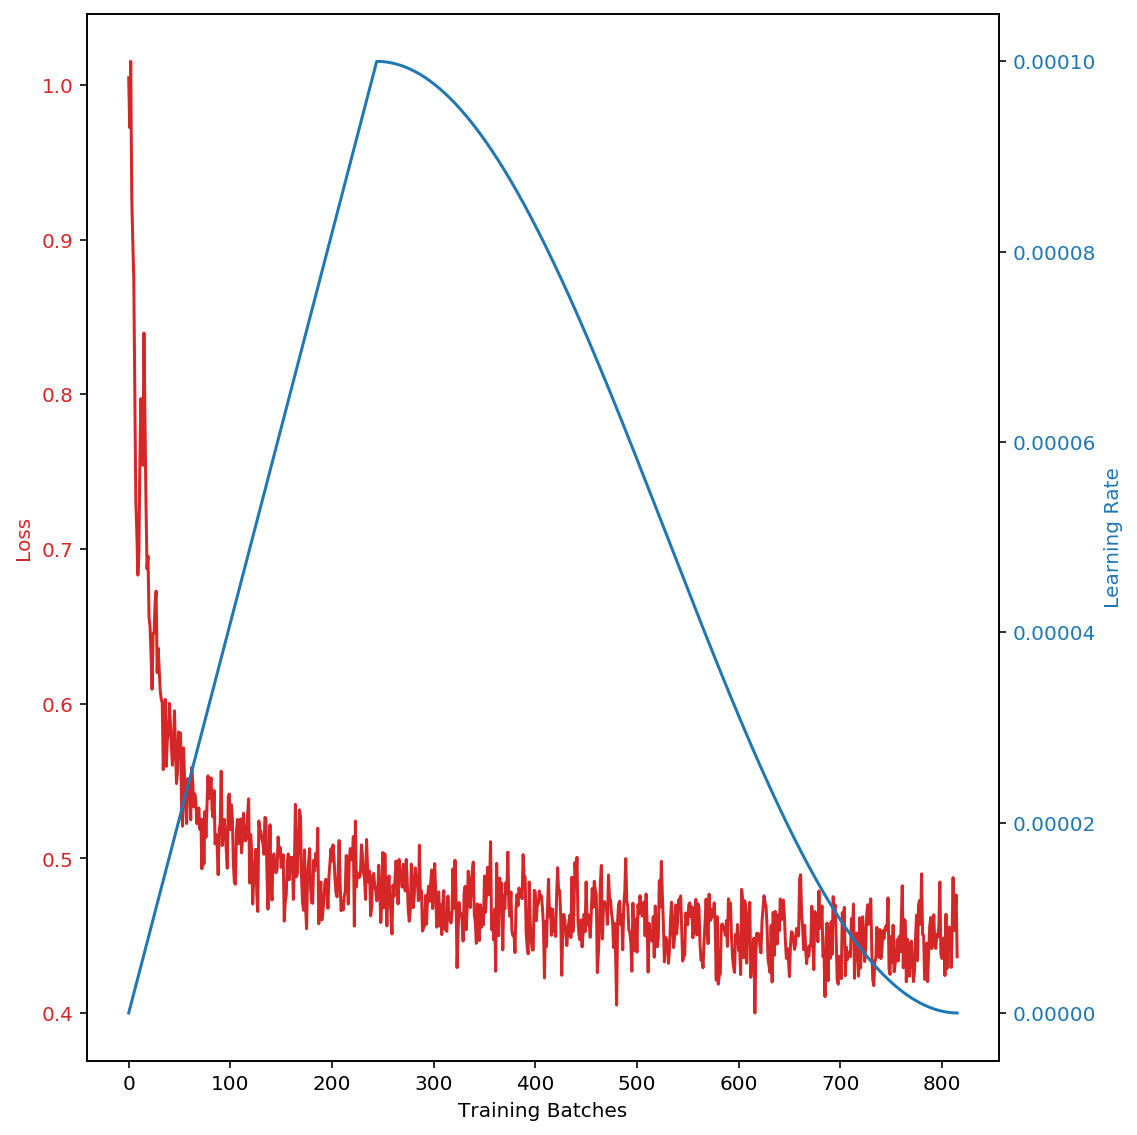

Proba       Preds    
         min   max   min max
Labels                      
0      0.005 0.544     0   1
1      0.005 0.546     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.495,"[0.5046037435531616, 0.49539628624916077]",0,1,0.463,"[0.5367630124092102, 0.4632369875907898]",0,0,0.484,"[0.5156912207603455, 0.48430877923965454]",0,0
1,0.467,"[0.5331155061721802, 0.4668845236301422]",0,1,0.058,"[0.9424941539764404, 0.05750580132007599]",0,0,0.479,"[0.5214051008224487, 0.47859495878219604]",0,1
2,0.478,"[0.5215041041374207, 0.47849589586257935]",0,1,0.464,"[0.5359055995941162, 0.4640944004058838]",0,1,0.498,"[0.501842200756073, 0.498157799243927]",0,1
3,0.504,"[0.49577391147613525, 0.5042260885238647]",1,0,0.478,"[0.5221670269966125, 0.47783297300338745]",0,0,0.462,"[0.5375398993492126, 0.46246013045310974]",0,1
4,0.449,"[0.5512950420379639, 0.4487049877643585]",0,0,0.436,"[0.5644972324371338, 0.4355027675628662]",0,0,0.203,"[0.7974177598953247, 0.20258229970932007]",0,0


scores =  {'map': '0.6052', 'acc': '0.5340', 'auc': '0.6466'}


train   val
mean_or_std metric               
mean        map       0.764 0.605
            accuracy  0.772 0.534
            auc       0.854 0.647
std         map       0.000 0.000
            accuracy  0.000 0.000
            auc       0.000 0.000

train                             val                     
    precision recall    f1  supoort precision recall    f1 supoort
neg     0.773  0.912 0.837 5450.000     0.520  0.884 0.655 250.000
pos     0.769  0.520 0.620 3050.000     0.613  0.184 0.283 250.000

In [21]:
adamw = torch.optim.AdamW
adamw_params = dict(lr=1e-4, betas=(0.9, 0.98), eps=1e-08, weight_decay=1e-2)
optimizer = adamw
optimizer_params = adamw_params

lr_strategy = {
    "model": {
        "lr": optimizer_params["lr"] / 1000,
        "finetune": False,
        "encoder": {
            "layer": {
                "2": {
                    "lr": optimizer_params["lr"] / 1e3,
                    "finetune": False
                },
                "3": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                },
                "4": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                },
                "5": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                }
            }
        },
    }
}

epochs = 24
batch_size = 256
model_fn = model_builder(AlbertClassifer,
                         dict(classifier_dims=256,
                              num_classes=2,
                              gaussian_noise=0.02,
                              dropout=0.02,
                              word_masking_proba=0.1,
                              internal_dims=512,
                              final_layer_builder=fb_1d_loss_builder,
                              n_layers=2,
                              n_encoders=3,
                              n_decoders=0,
                              n_tokens_in=96,
                              n_tokens_out=48,
                              featurizer="transformer",
                              model='./distilbert-nsp',
                              loss="focal",
                              classification_head="decoder_ensemble", # head_ensemble
                              dice_loss_coef=0.0,
                              auc_loss_coef=1.0,
                              attention_drop_proba=0.1,
                              finetune=False),
                         per_param_opts_fn=lr_strategy,
                         optimiser_class=optimizer,
                         optimiser_params=optimizer_params)

kfold = False
results, prfs = train_validate_ntimes(
    model_fn,
    data,
    batch_size,
    epochs,
    kfold=kfold,
    scheduler_init_fn=scheduler_init_fn,
    model_call_back=reg_sched, # reg_sched
    validation_epochs=[4, 7, 9, 11, 14, 17, 19, 23, 27, 31, 34, 37, 41, 44, 47, 51, 54],
    show_model_stats=False,
    sampling_policy="without_replacement")
r2, p2 = results, prfs
results
prfs

# auc_loss_coef=0.5
# 0.853 0.661 (0.757 0.596) gaussian_noise=0.1, dropout=0.2, word_masking_proba=0.2,
# 0.852	0.658 (0.748	0.604) gaussian_noise=0.1, dropout=0.15, word_masking_proba=0.2,
# 0.857	0.661 (0.761	0.590) gaussian_noise=0.1, dropout=0.15, word_masking_proba=0.15,
# 0.845	0.657 (0.757	0.592) gaussian_noise=0.1, dropout=0.25, word_masking_proba=0.25,
# 0.841	0.644 (0.753	0.578) gaussian_noise=0.1, dropout=0.25, word_masking_proba=0.2,
# 0.861	0.647 (0.759	0.594) gaussian_noise=0.1, dropout=0.15, word_masking_proba=0.15,
# 0.857	0.652 (0.756	0.576) gaussian_noise=0.1, dropout=0.15, word_masking_proba=0.15,
# 0.848	0.661 (0.751	0.592) gaussian_noise=0.1, dropout=0.15, word_masking_proba=0.15,
# 0.853	0.657 (0.755	0.588) gaussian_noise=0.1, dropout=0.2, word_masking_proba=0.2,
# 0.853	0.661 (0.750	0.602) gaussian_noise=0.1, dropout=0.2, word_masking_proba=0.2,
# 0.852	0.649 (0.757	0.578) gaussian_noise=0.1, dropout=0.2, word_masking_proba=0.2,

# No reg_sched testing
# 0.848	0.652 (0.754	0.590) gaussian_noise=0.1, dropout=0.2, word_masking_proba=0.2,

# Cnn1D head


In [ ]:
adamw = torch.optim.AdamW
adamw_params = dict(lr=1e-4, betas=(0.9, 0.98), eps=1e-08, weight_decay=1e-2)
optimizer = adamw
optimizer_params = adamw_params

lr_strategy = {
    "model": {
        "lr": optimizer_params["lr"] / 1000,
        "finetune": False,
        "encoder": {
            "layer": {
                "2": {
                    "lr": optimizer_params["lr"] / 1e3,
                    "finetune": False
                },
                "3": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                },
                "4": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                },
                "5": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                }
            }
        },
    }
}

epochs = 24
batch_size = 256
model_fn = model_builder(AlbertClassifer,
                         dict(classifier_dims=256,
                              num_classes=2,
                              gaussian_noise=0.1,
                              dropout=0.01,
                              word_masking_proba=0.1,
                              internal_dims=512,
                              final_layer_builder=fb_1d_loss_builder,
                              n_layers=2,
                              n_encoders=3,
                              n_decoders=0,
                              n_tokens_in=96,
                              n_tokens_out=48,
                              featurizer="transformer",
                              model='distilbert-cor-nsp',
                              loss="focal",
                              classification_head="decoder_ensemble", # head_ensemble
                              dice_loss_coef=0.0,
                              auc_loss_coef=1.0,
                              attention_drop_proba=0.05,
                              finetune=False),
                         per_param_opts_fn=lr_strategy,
                         optimiser_class=optimizer,
                         optimiser_params=optimizer_params)

kfold = False
results, prfs = train_validate_ntimes(
    model_fn,
    data,
    batch_size,
    epochs,
    kfold=kfold,
    scheduler_init_fn=scheduler_init_fn,
    model_call_back=reg_sched, # reg_sched
    validation_epochs=[4, 7, 9, 11, 14, 17, 19, 23, 27, 31, 34, 37, 41, 44, 47, 51, 54],
    show_model_stats=False,
    sampling_policy="without_replacement")
r2, p2 = results, prfs
results
prfs

# auc_loss_coef=0.5
# 0.853 0.661 (0.757 0.596) gaussian_noise=0.1, dropout=0.2, word_masking_proba=0.2,
# 0.852	0.658 (0.748	0.604) gaussian_noise=0.1, dropout=0.15, word_masking_proba=0.2,
# 0.857	0.661 (0.761	0.590) gaussian_noise=0.1, dropout=0.15, word_masking_proba=0.15,
# 0.845	0.657 (0.757	0.592) gaussian_noise=0.1, dropout=0.25, word_masking_proba=0.25,
# 0.841	0.644 (0.753	0.578) gaussian_noise=0.1, dropout=0.25, word_masking_proba=0.2,
# 0.861	0.647 (0.759	0.594) gaussian_noise=0.1, dropout=0.15, word_masking_proba=0.15,
# 0.857	0.652 (0.756	0.576) gaussian_noise=0.1, dropout=0.15, word_masking_proba=0.15,
# 0.848	0.661 (0.751	0.592) gaussian_noise=0.1, dropout=0.15, word_masking_proba=0.15,
# 0.853	0.657 (0.755	0.588) gaussian_noise=0.1, dropout=0.2, word_masking_proba=0.2,
# 0.853	0.661 (0.750	0.602) gaussian_noise=0.1, dropout=0.2, word_masking_proba=0.2,
# 0.852	0.649 (0.757	0.578) gaussian_noise=0.1, dropout=0.2, word_masking_proba=0.2,

# No reg_sched testing
# 0.848	0.652 (0.754	0.590) gaussian_noise=0.1, dropout=0.2, word_masking_proba=0.2,

# Cnn1D head


# Predict

In [12]:
adamw = torch.optim.AdamW
adamw_params = dict(lr=1e-4, betas=(0.9, 0.98), eps=1e-08, weight_decay=1e-2)
optimizer = adamw
optimizer_params = adamw_params

lr_strategy = {
    "model": {
        "lr": optimizer_params["lr"] / 1000,
        "finetune": False,
        "encoder": {
            "layer": {
                "2": {
                    "lr": optimizer_params["lr"] / 1e3,
                    "finetune": False
                },
                "3": {
                    "lr": optimizer_params["lr"] / 1e1,
                    "finetune": True
                },
                "4": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                },
                "5": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                }
            }
        },
    }
}

epochs = 24
batch_size = 256
model_fn = model_builder(AlbertClassifer,
                         dict(classifier_dims=256,
                              num_classes=2,
                              gaussian_noise=0.1,
                              dropout=0.2,
                              word_masking_proba=0.2,
                              internal_dims=512,
                              final_layer_builder=fb_1d_loss_builder,
                              n_layers=2,
                              n_encoders=3,
                              n_decoders=3,
                              n_tokens_in=96,
                              n_tokens_out=32,
                              featurizer="transformer",
                              model='./distilbert-nsp',
                              loss="focal",
                              classification_head="decoder_ensemble", # decoder_ensemble
                              dice_loss_coef=0.0,
                              auc_loss_coef=0.5,
                              attention_drop_proba=0.2,
                              finetune=False),
                         per_param_opts_fn=lr_strategy,
                         optimiser_class=optimizer,
                         optimiser_params=optimizer_params)


Autocast =  True Epochs =  48 Divisor = 2 Examples = 3050 Batch Size =  256
Training Samples =  6100 Weighted Sampling =  True Num Batches =  12 Accumulation steps =  1



Epoch =  1 Loss = 0.979856 LR = 0.00000001



Epoch =  2 Loss = 0.758919 LR = 0.00000001



Epoch =  3 Loss = 0.645848 LR = 0.00000002



Epoch =  4 Loss = 0.561513 LR = 0.00000003



Epoch =  5 Loss = 0.514693 LR = 0.00000003



Epoch =  6 Loss = 0.484570 LR = 0.00000004



Epoch =  7 Loss = 0.457672 LR = 0.00000005



Epoch =  8 Loss = 0.445202 LR = 0.00000006



Epoch =  9 Loss = 0.429538 LR = 0.00000006



Epoch =  10 Loss = 0.417026 LR = 0.00000007



Epoch =  11 Loss = 0.405561 LR = 0.00000008



Epoch =  12 Loss = 0.400622 LR = 0.00000008



Epoch =  13 Loss = 0.393892 LR = 0.00000009



Epoch =  14 Loss = 0.385446 LR = 0.00000010



Epoch =  15 Loss = 0.374409 LR = 0.00000010


Proba       Preds    
         min   max   min max
Labels                      
0      0.270 0.674     0   1
1      0.271 0.665     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.357,"[0.6433148384094238, 0.35668516159057617]",0,1,0.374,"[0.6262749433517456, 0.3737250864505768]",0,1,0.464,"[0.5364686846733093, 0.4635312855243683]",0,0
1,0.561,"[0.4388529658317566, 0.5611470937728882]",1,1,0.674,"[0.32643285393714905, 0.6735672354698181]",1,0,0.424,"[0.5763609409332275, 0.42363908886909485]",0,1
2,0.461,"[0.5391199588775635, 0.4608800709247589]",0,0,0.369,"[0.6311071515083313, 0.3688928484916687]",0,1,0.516,"[0.4844038486480713, 0.5155961513519287]",1,1
3,0.575,"[0.42491117119789124, 0.5750888586044312]",1,1,0.329,"[0.6708016991615295, 0.32919833064079285]",0,0,0.271,"[0.7285424470901489, 0.27145761251449585]",0,1
4,0.329,"[0.6708016991615295, 0.32919833064079285]",0,0,0.298,"[0.7019307017326355, 0.2980693578720093]",0,0,0.423,"[0.5770429372787476, 0.4229571521282196]",0,0


scores =  {'map': '0.5668', 'acc': '0.5540', 'auc': '0.5940'}
Epoch =  15 Train = 0.721553 Val = 0.594048



Epoch =  16 Loss = 0.366131 LR = 0.00000010



Epoch =  17 Loss = 0.361651 LR = 0.00000010



Epoch =  18 Loss = 0.356667 LR = 0.00000010



Epoch =  19 Loss = 0.357514 LR = 0.00000010



Epoch =  20 Loss = 0.348290 LR = 0.00000009



Epoch =  21 Loss = 0.346723 LR = 0.00000009



Epoch =  22 Loss = 0.341159 LR = 0.00000009



Epoch =  23 Loss = 0.337749 LR = 0.00000008



Epoch =  24 Loss = 0.334492 LR = 0.00000008



Epoch =  25 Loss = 0.332854 LR = 0.00000008



Epoch =  26 Loss = 0.339877 LR = 0.00000007



Epoch =  27 Loss = 0.334182 LR = 0.00000007



Epoch =  28 Loss = 0.327006 LR = 0.00000006



Epoch =  29 Loss = 0.325177 LR = 0.00000006



Epoch =  30 Loss = 0.329125 LR = 0.00000006



Epoch =  31 Loss = 0.326187 LR = 0.00000005


Proba       Preds    
         min   max   min max
Labels                      
0      0.072 0.570     0   1
1      0.141 0.580     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.213,"[0.7872404456138611, 0.2127595841884613]",0,0,0.422,"[0.5778605341911316, 0.4221394658088684]",0,0,0.415,"[0.5851396322250366, 0.41486039757728577]",0,0
1,0.494,"[0.5056682229042053, 0.49433183670043945]",0,1,0.481,"[0.5189900398254395, 0.48100998997688293]",0,1,0.420,"[0.5797954201698303, 0.42020466923713684]",0,0
2,0.475,"[0.5254788994789124, 0.47452113032341003]",0,0,0.354,"[0.6461704969406128, 0.353829562664032]",0,1,0.526,"[0.47382619976997375, 0.5261738896369934]",1,0
3,0.479,"[0.5214900970458984, 0.47850990295410156]",0,1,0.494,"[0.5063291192054749, 0.49367091059684753]",0,0,0.460,"[0.5399042367935181, 0.4600957930088043]",0,1
4,0.451,"[0.5491696000099182, 0.4508303701877594]",0,1,0.504,"[0.4956133961677551, 0.5043866038322449]",1,0,0.467,"[0.5325141549110413, 0.4674859046936035]",0,0


scores =  {'map': '0.6089', 'acc': '0.5460', 'auc': '0.6251'}
Epoch =  31 Train = 0.779935 Val = 0.625056



Epoch =  32 Loss = 0.325384 LR = 0.00000005



Epoch =  33 Loss = 0.318821 LR = 0.00000004



Epoch =  34 Loss = 0.322382 LR = 0.00000004


Proba       Preds    
         min   max   min max
Labels                      
0      0.095 0.609     0   1
1      0.157 0.626     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.508,"[0.4923440217971802, 0.5076559782028198]",1,1,0.329,"[0.6707705855369568, 0.3292294442653656]",0,1,0.517,"[0.4828476309776306, 0.5171523690223694]",1,1
1,0.487,"[0.5126412510871887, 0.48735880851745605]",0,1,0.530,"[0.4699740707874298, 0.5300258994102478]",1,0,0.378,"[0.6218031644821167, 0.3781968057155609]",0,0
2,0.506,"[0.49389776587486267, 0.5061022639274597]",1,0,0.455,"[0.5452865958213806, 0.45471349358558655]",0,0,0.285,"[0.7152751684188843, 0.2847249209880829]",0,0
3,0.384,"[0.6159346103668213, 0.3840654194355011]",0,0,0.600,"[0.4002881944179535, 0.5997118949890137]",1,0,0.439,"[0.5606936812400818, 0.4393063187599182]",0,0
4,0.115,"[0.8845508098602295, 0.1154492050409317]",0,0,0.503,"[0.49714961647987366, 0.5028504133224487]",1,0,0.381,"[0.6193755269050598, 0.3806244730949402]",0,1


scores =  {'map': '0.5891', 'acc': '0.5560', 'auc': '0.6111'}
Epoch =  34 Train = 0.780952 Val = 0.611096



Epoch =  35 Loss = 0.319285 LR = 0.00000003



Epoch =  36 Loss = 0.316662 LR = 0.00000003



Epoch =  37 Loss = 0.313579 LR = 0.00000002



Epoch =  38 Loss = 0.313909 LR = 0.00000002



Epoch =  39 Loss = 0.311739 LR = 0.00000002



Epoch =  40 Loss = 0.311923 LR = 0.00000001



Epoch =  41 Loss = 0.313768 LR = 0.00000001



Epoch =  42 Loss = 0.310999 LR = 0.00000001


Proba       Preds    
         min   max   min max
Labels                      
0      0.115 0.649     0   1
1      0.170 0.661     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.466,"[0.5343939065933228, 0.46560612320899963]",0,0,0.295,"[0.704501748085022, 0.2954983115196228]",0,1,0.461,"[0.5392455458641052, 0.4607544541358948]",0,1
1,0.505,"[0.49506014585494995, 0.5049399137496948]",1,1,0.543,"[0.4572490453720093, 0.5427509546279907]",1,0,0.519,"[0.4810548722743988, 0.5189451575279236]",1,0
2,0.515,"[0.4845357835292816, 0.5154642462730408]",1,1,0.356,"[0.6441943645477295, 0.35580572485923767]",0,0,0.324,"[0.675918459892273, 0.32408156991004944]",0,0
3,0.569,"[0.4310528337955475, 0.5689471960067749]",1,0,0.584,"[0.415558397769928, 0.5844416618347168]",1,0,0.520,"[0.47958993911743164, 0.5204100608825684]",1,0
4,0.506,"[0.4940480589866638, 0.505952000617981]",1,1,0.568,"[0.43249645829200745, 0.5675035119056702]",1,1,0.440,"[0.5595294237136841, 0.4404706060886383]",0,0


scores =  {'map': '0.5890', 'acc': '0.5800', 'auc': '0.6182'}
Epoch =  42 Train = 0.789715 Val = 0.618168



Epoch =  43 Loss = 0.310799 LR = 0.00000001



Epoch =  44 Loss = 0.312568 LR = 0.00000000



Epoch =  45 Loss = 0.305018 LR = 0.00000000



Epoch =  46 Loss = 0.307765 LR = 0.00000000



Epoch =  47 Loss = 0.312203 LR = 0.00000000



Epoch =  48 Loss = 0.307219 LR = 0.00000000



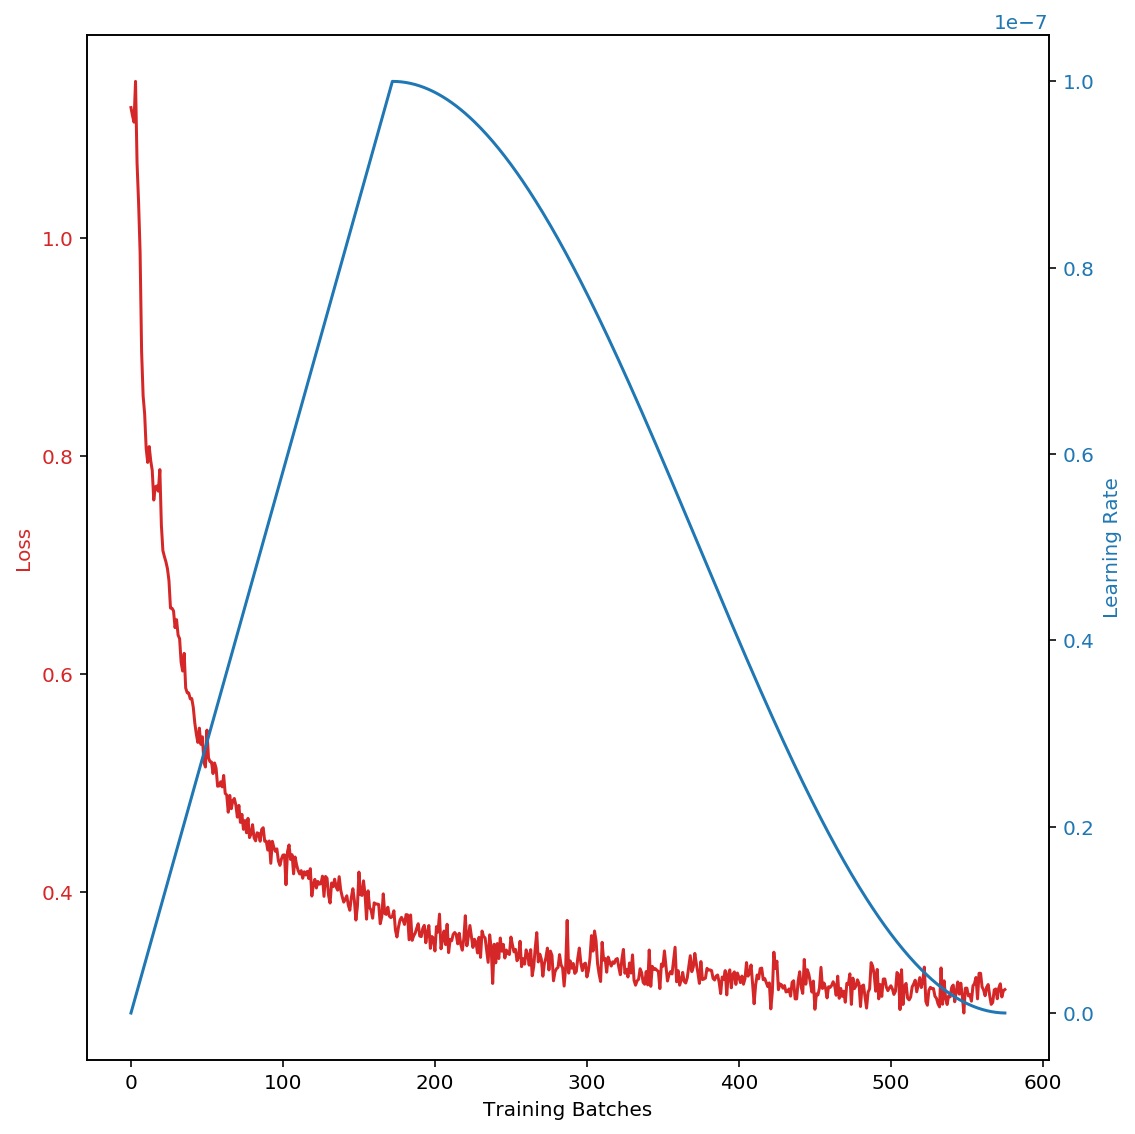

,id,proba,label
522,78956,0.548,1
357,91637,0.578,1
604,68172,0.571,1
100,49267,0.522,1
776,63097,0.193,0


In [13]:
submission, text_model = train_and_predict(model_fn, data, batch_size, epochs, 
                                           scheduler_init_fn=scheduler_init_fn, 
                                           model_call_back=reg_sched,
                                           sampling_policy="without_replacement",
                                           validation_epochs=[15, 31, 34, 42],
                                          )
submission.to_csv("submission.csv",index=False)
submission.sample(5)
